[View in Colaboratory](https://colab.research.google.com/github/HUSTneeb/GoogleColabCode/blob/master/TensorFlowLearningTFhub.ipynb)

In [0]:
!pip install --quiet "tensorflow>=1.7"
!pip install -q tensorflow-hub
!pip install -q seaborn

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns


In [5]:
def load_directory_data(directory):
  data={}
  data['sentence']=[]
  data['sentiment']=[]
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory,file_path),'r') as f:
      data['sentence'].append(f.read())
      data['sentiment'].append(re.match("\d+_(\d+)\.txt",file_path).group(1))
  return pd.DataFrame.from_dict(data)

def load_dataset(directory):
  pos_df=load_directory_data(os.path.join(directory,'pos'))
  neg_df=load_directory_data(os.path.join(directory,'neg'))
  pos_df['polarity']=1
  neg_df['polarity']=0
  return pd.concat([pos_df,neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
  dataset=tf.keras.utils.get_file(
  fname='aclImdb.tar.gz',
  origin='http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
  extract=True)
  
  train_df=load_dataset(os.path.join(os.path.dirname(dataset),
                                    'aclImdb','train'))
  test_df=load_dataset(os.path.join(os.path.dirname(dataset),
                                   'aclImdb','test'))
  return train_df,test_df

tf.logging.set_verbosity(tf.logging.ERROR)

train_df,test_df=download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,Despite the gravity of the subject and probabl...,2,0
1,As the number of Video Nasties I've yet to see...,2,0
2,This is a really interesting movie. It is an a...,7,1
3,I began watching this movie with low expectati...,4,0
4,"Of course the average ""Sci-Fi"" Battle Star Gal...",10,1


In [0]:
train_input_fn=tf.estimator.inputs.pandas_input_fn(
  train_df,train_df['polarity'],num_epochs=None,shuffle=True)

predict_train_input_fn=tf.estimator.inputs.pandas_input_fn(
  train_df,train_df['polarity'],shuffle=False)
predict_test_input_fn=tf.estimator.inputs.pandas_input_fn(
  test_df,test_df['polarity'],shuffle=False)

In [7]:
embedded_text_feature_column=hub.text_embedding_column(
  key='sentence',
  module_spec="http://tfhub.dev/google/nnlm-en-dim128/1")

estimator=tf.estimator.DNNClassifier(
  hidden_units=[500,100],
  feature_columns=[embedded_text_feature_column],n_classes=2,optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))
estimator.train(input_fn=train_input_fn,steps=1000)

In [0]:
train_eval_result=estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result=estimator.evaluate(input_fn=predict_test_input_fn)



In [17]:
print(format(train_eval_result))
print(test_eval_result)

{'accuracy': 0.79848, 'accuracy_baseline': 0.5, 'auc': 0.88277423, 'auc_precision_recall': 0.88273084, 'average_loss': 0.43353328, 'label/mean': 0.5, 'loss': 55.29761, 'precision': 0.8224162, 'prediction/mean': 0.47211263, 'recall': 0.76136, 'global_step': 1000}
{'accuracy': 0.79056, 'accuracy_baseline': 0.5, 'auc': 0.87565553, 'auc_precision_recall': 0.87766707, 'average_loss': 0.44514048, 'label/mean': 0.5, 'loss': 56.778122, 'precision': 0.81809425, 'prediction/mean': 0.46913597, 'recall': 0.74728, 'global_step': 1000}


Text(51,0.5,'True')

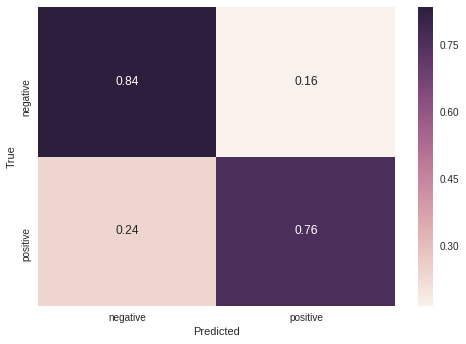

In [19]:
def get_predictions(estimator,input_fn):
  return[x['class_ids'][0] for x in estimator.predict(input_fn=input_fn)]

LABELS=['negative','positive']

with tf.Graph().as_default():
  cm=tf.confusion_matrix(train_df['polarity'],
                        get_predictions(estimator,predict_train_input_fn))
  with tf.Session() as session:
    cm_out=session.run(cm)
    
cm_out=cm_out.astype(float)/cm_out.sum(axis=1)[:,np.newaxis]
sns.heatmap(cm_out,annot=True,xticklabels=LABELS,yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")